In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/animal_images'

image_paths = []
labels = []

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        image_paths.append(img_path)
        labels.append(class_name)

print("Total Images:", len(image_paths))
print("Classes:", set(labels))


Total Images: 3166
Classes: {'African_Elephant', 'Rhino', 'Jaguars', 'cheetahs', 'Lion', 'Amur_Leopard', 'Orangutan', 'Panda', 'Arctic_Fox', 'Panthers', 'Chimpanzee'}


In [ ]:
def preprocess_image(img):
    img = cv2.imread(img_path)  # Read image
    img = cv2.resize(img, (224,224))  # Resize
    img = img / 255.0  # Normalize
    return img

processed_images = []

for img_path in image_paths:
    img = preprocess_image(img_path)
    processed_images.append(img)

processed_images = np.array(processed_images)
print("After Preprocessing, Images Shape:", processed_images.shape)


After Preprocessing, Images Shape: (3166, 224, 224, 3)


In [ ]:
def enhance_image(img):
    lab = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced = cv2.merge((cl,a,b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    enhanced = enhanced / 255.0
    return enhanced

# Apply enhancement
for i in range(len(processed_images)):
    processed_images[i] = enhance_image(processed_images[i])

print("Enhancement Done")


Enhancement Done


In [ ]:
def segment_image(img):
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    segmented = cv2.bitwise_and((img*255).astype(np.uint8), (img*255).astype(np.uint8), mask=mask)
    segmented = segmented / 255.0
    return segmented

# Apply segmentation
for i in range(len(processed_images)):
    processed_images[i] = segment_image(processed_images[i])

print("Segmentation Done")


Segmentation Done


In [ ]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)
num_classes = len(le.classes_)
print("Number of Classes:", num_classes)
print("Classes:", le.classes_)


Number of Classes: 11
Classes: ['African_Elephant' 'Amur_Leopard' 'Arctic_Fox' 'Chimpanzee' 'Jaguars'
 'Lion' 'Orangutan' 'Panda' 'Panthers' 'Rhino' 'cheetahs']


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add more dense layers with normalization and dropout
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Final output layer
predictions = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,350,987 (100.52 MB)

 Trainable params: 2,760,203 (10.53 MB)

 Non-trainable params: 23,590,784 (89.99 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint



history = model.fit(
    processed_images, labels_encoded,
    epochs=25,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint]
)


Epoch 1/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1444 - loss: 2.4583
Epoch 1: saving model to /content/drive/MyDrive/animal_model_epoch_01.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.1446 - loss: 2.4572 - val_accuracy: 0.0000e+00 - val_loss: 5.0454
Epoch 2/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2336 - loss: 2.0354
Epoch 2: saving model to /content/drive/MyDrive/animal_model_epoch_02.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.2336 - loss: 2.0352 - val_accuracy: 0.0000e+00 - val_loss: 5.1858
Epoch 3/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2565 - loss: 1.9584
Epoch 3: saving model to /content/drive/MyDrive/animal_model_epoch_03.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.2567 - loss: 1.9579 - val_accuracy: 0.0110 - val_loss: 5.4873
Epoch 4/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2846 - loss: 1.8836
Epoch 4: saving model to /content/drive/MyDrive/animal_model_epoch_04.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.2848 - loss: 1.8834 - val_accuracy: 0.0126 - val_loss: 5.7888
Epoch 5/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3064 - loss: 1.8346
Epoch 5: saving model to /content/drive/MyDrive/animal_model_epoch_05.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.3064 - loss: 1.8346 - val_accuracy: 0.0126 - val_loss: 5.8356
Epoch 6/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3265 - loss: 1.8057
Epoch 6: saving model to /content/drive/MyDrive/animal_model_epoch_06.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.3264 - loss: 1.8057 - val_accuracy: 0.0142 - val_loss: 5.9912
Epoch 7/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3302 - loss: 1.7747
Epoch 7: saving model to /content/drive/MyDrive/animal_model_epoch_07.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.3302 - loss: 1.7746 - val_accuracy: 0.0126 - val_loss: 6.1926
Epoch 8/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3333 - loss: 1.7418
Epoch 8: saving model to /content/drive/MyDrive/animal_model_epoch_08.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.3334 - loss: 1.7418 - val_accuracy: 0.0126 - val_loss: 6.3825
Epoch 9/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3565 - loss: 1.7314
Epoch 9: saving model to /content/drive/MyDrive/animal_model_epoch_09.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.3565 - loss: 1.7314 - val_accuracy: 0.0126 - val_loss: 6.4840
Epoch 10/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3524 - loss: 1.7217
Epoch 10: saving model to /content/drive/MyDrive/animal_model_epoch_10.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.3524 - loss: 1.7216 - val_accuracy: 0.0110 - val_loss: 6.6716
Epoch 11/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3586 - loss: 1.7149
Epoch 11: saving model to /content/drive/MyDrive/animal_model_epoch_11.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.3587 - loss: 1.7148 - val_accuracy: 0.0126 - val_loss: 6.8612
Epoch 12/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3779 - loss: 1.6557
Epoch 12: saving model to /content/drive/MyDrive/animal_model_epoch_12.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.3778 - loss: 1.6557 - val_accuracy: 0.0095 - val_loss: 6.8816
Epoch 13/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3772 - loss: 1.6574
Epoch 13: saving model to /content/drive/MyDrive/animal_model_epoch_13.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.3772 - loss: 1.6575 - val_accuracy: 0.0110 - val_loss: 6.8512
Epoch 14/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4119 - loss: 1.6214
Epoch 14: saving model to /content/drive/MyDrive/animal_model_epoch_14.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.4117 - loss: 1.6216 - val_accuracy: 0.0126 - val_loss: 7.2756
Epoch 15/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3963 - loss: 1.6302
Epoch 15: saving model to /content/drive/MyDrive/animal_model_epoch_15.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.3963 - loss: 1.6302 - val_accuracy: 0.0126 - val_loss: 7.6912
Epoch 16/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3980 - loss: 1.6181
Epoch 16: saving model to /content/drive/MyDrive/animal_model_epoch_16.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.3980 - loss: 1.6181 - val_accuracy: 0.0095 - val_loss: 7.6832
Epoch 17/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4351 - loss: 1.5616
Epoch 17: saving model to /content/drive/MyDrive/animal_model_epoch_17.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.4350 - loss: 1.5619 - val_accuracy: 0.0110 - val_loss: 7.6521
Epoch 18/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4145 - loss: 1.5749
Epoch 18: saving model to /content/drive/MyDrive/animal_model_epoch_18.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4144 - loss: 1.5750 - val_accuracy: 0.0095 - val_loss: 7.9542
Epoch 19/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3915 - loss: 1.6154
Epoch 19: saving model to /content/drive/MyDrive/animal_model_epoch_19.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.3916 - loss: 1.6153 - val_accuracy: 0.0110 - val_loss: 7.8846
Epoch 20/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4206 - loss: 1.5726
Epoch 20: saving model to /content/drive/MyDrive/animal_model_epoch_20.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.4207 - loss: 1.5724 - val_accuracy: 0.0110 - val_loss: 8.2789
Epoch 21/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4235 - loss: 1.5481
Epoch 21: saving model to /content/drive/MyDrive/animal_model_epoch_21.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.4235 - loss: 1.5482 - val_accuracy: 0.0110 - val_loss: 8.3300
Epoch 22/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4336 - loss: 1.5416
Epoch 22: saving model to /content/drive/MyDrive/animal_model_epoch_22.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.4334 - loss: 1.5416 - val_accuracy: 0.0110 - val_loss: 8.5091
Epoch 23/25
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4404 - loss: 1.5343
Epoch 23: saving model to /content/drive/MyDrive/animal_model_epoch_23.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.4403 - loss: 1.5343 - val_accuracy: 0.0095 - val_loss: 8.5588
Epoch 24/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4342 - loss: 1.5217
Epoch 24: saving model to /content/drive/MyDrive/animal_model_epoch_24.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.4342 - loss: 1.5217 - val_accuracy: 0.0126 - val_loss: 8.6981
Epoch 25/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4561 - loss: 1.5147
Epoch 25: saving model to /content/drive/MyDrive/animal_model_epoch_25.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.4561 - loss: 1.5146 - val_accuracy: 0.0110 - val_loss: 8.8573


In [ ]:
model.save('/content/drive/MyDrive/animal_model.h5')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the final saved model
model = load_model('/content/drive/MyDrive/animal_model.h5')
print("✅ Model loaded successfully")


✅ Model loaded successfully


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Get Predictions
y_pred_probs = model.predict(processed_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(labels_encoded, axis=1)

# ✅ Step 2: Classification Report
print("=== Classification Report ===\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# ✅ Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# ✅ Step 4: Optional — Calculate Overall Accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


NameError: name 'processed_images' is not defined

In [ ]:
!pip install tensorflow scikit-learn matplotlib --quiet


In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = "/content/drive/MyDrive/animal_images"
model_path = "/content/resnet50_animals.h5"


In [ ]:
split_dir = "/content/dataset_split"

# Create train/val/test folders for each class
for split in ["train", "val", "test"]:
    for cls in os.listdir(dataset_dir):
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

In [ ]:
# Split dataset 80/10/10
for cls in os.listdir(dataset_dir):
    images = os.listdir(os.path.join(dataset_dir, cls))
    random.shuffle(images)
    n = len(images)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)

    for i, img in enumerate(images):
        if i < train_end:
            dst = os.path.join(split_dir, "train", cls, img)
        elif i < val_end:
            dst = os.path.join(split_dir, "val", cls, img)
        else:
            dst = os.path.join(split_dir, "test", cls, img)
        shutil.copy(os.path.join(dataset_dir, cls, img), dst)

print(" Dataset split completed!")


 Dataset split completed!


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dir, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    os.path.join(split_dir, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(split_dir, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------

Found 2530 images belonging to 11 classes.
Found 315 images belonging to 11 classes.
Found 321 images belonging to 11 classes.


In [ ]:
y_train = train_generator.classes
classes = list(train_generator.class_indices.keys())
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9583333333333334), 1: np.float64(0.9583333333333334), 2: np.float64(1.0900473933649288), 3: np.float64(1.0), 4: np.float64(1.0900473933649288), 5: np.float64(0.9236947791164659), 6: np.float64(0.9465020576131687), 7: np.float64(0.9663865546218487), 8: np.float64(0.9236947791164659), 9: np.float64(1.4110429447852761), 10: np.float64(0.8984375)}


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save(model_path)
print(f"✅ Model saved at {model_path}")

✅ Model saved at /content/resnet50_animals.h5


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


321/321 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


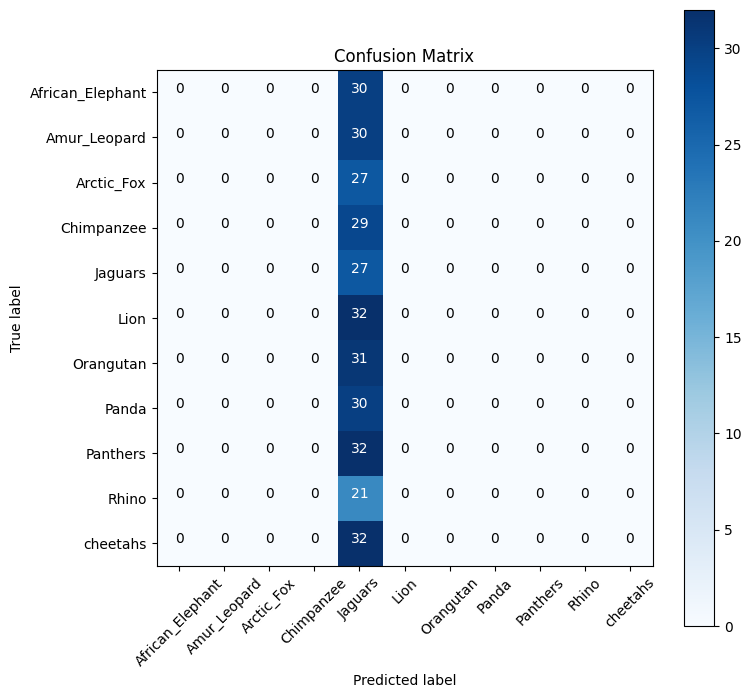

                  precision    recall  f1-score   support

African_Elephant       0.00      0.00      0.00        30
    Amur_Leopard       0.00      0.00      0.00        30
      Arctic_Fox       0.00      0.00      0.00        27
      Chimpanzee       0.00      0.00      0.00        29
         Jaguars       0.08      1.00      0.16        27
            Lion       0.00      0.00      0.00        32
       Orangutan       0.00      0.00      0.00        31
           Panda       0.00      0.00      0.00        30
        Panthers       0.00      0.00      0.00        32
           Rhino       0.00      0.00      0.00        21
        cheetahs       0.00      0.00      0.00        32

        accuracy                           0.08       321
       macro avg       0.01      0.09      0.01       321
    weighted avg       0.01      0.08      0.01       321



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)

In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")


✅ Test Accuracy: 8.41%
